
# MCTS Log Analysis Notebook

This notebook parses your **FastLogger** logs produced by `main.py`, aggregates metrics across runs, and helps compare **MCTS parameter settings** (coverage, MSE, entropy) for different fields and start positions.

> **Setup:** Set `TRIALS_ROOT` below to the folder that contains your experiment folders (e.g., `/home/bota/Desktop/active_sensing_extended_planner/trials`).  
> The notebook is robust to both the **old** log row format and the **new** format that includes `Action` and `IG` columns.


In [83]:
import os, re, json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔧 SET THIS to your trials root (parent directory containing many run folders)
TRIALS_ROOT = os.environ.get(
    "TRIALS_ROOT", "/home/bota/Desktop/active_sensing_extended_planner/trials"
)

print("TRIALS_ROOT =", TRIALS_ROOT)


# Utility: safe float
def _to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

TRIALS_ROOT = /home/bota/Desktop/active_sensing_extended_planner/trials


In [84]:
import json

header_re = {
    "strategy": re.compile(r"^Strategy:\s*(.+)\s*$", re.I),
    "pairwise": re.compile(r"^Pairwise:\s*(.+)\s*$", re.I),
    "n_agents": re.compile(r"^N agents:\s*(\d+)\s*$", re.I),
    "error": re.compile(r"^Error margin:\s*(.+)\s*$", re.I),
    "radius": re.compile(r"^Gaussian radius\s+([^\s]+)", re.I),
    "grid": re.compile(r"^Grid info:\s*(.+)$", re.I),
    "init": re.compile(r"^init UAV position:\s*(.+)$", re.I),
    "mcts_params": re.compile(r"^mcts_params:\s*(\{.*\})\s*$", re.I),
}

# Row formats
row_new = re.compile(
    r"^\s*(\d+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+(\S+)\s+([\d.eE+-]+|-)\s*$"
)
row_old = re.compile(
    r"^\s*(\d+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s*$"
)
actions_line = re.compile(r"^actions:\s*(.*)$", re.I)


def parse_log_sections(text):
    """Yield sections: (header_dict, rows) where rows is list of dicts"""
    lines = text.splitlines()
    i = 0
    current = {"mcts_params": None}
    rows = []
    while i < len(lines):
        line = lines[i].rstrip()
        if header_re["strategy"].match(line):
            # flush previous
            if rows:
                yield current, rows
                rows = []
            # new header
            current = {"mcts_params": None}
            # read header block until table header 'Step'
            while i < len(lines) and not lines[i].lstrip().startswith("Step"):
                l = lines[i].rstrip()
                for k, rgx in header_re.items():
                    m = rgx.match(l)
                    if m:
                        if k == "mcts_params":
                            try:
                                current[k] = json.loads(m.group(1))
                            except Exception:
                                current[k] = None
                        else:
                            current[k] = m.group(1)
                i += 1
            # skip table header + delimiter
            while i < len(lines) and (
                lines[i].strip().lower().startswith("step")
                or set(lines[i].strip()) == set("-")
            ):
                i += 1
            continue
        # parse row
        m = row_new.match(line)
        if m:
            step, ent, mse, h, cov, act, ig = m.groups()
            rows.append(
                dict(
                    step=int(step),
                    entropy=_to_float(ent),
                    mse=_to_float(mse),
                    height=_to_float(h),
                    coverage=_to_float(cov),
                    action=None if act == "-" else act,
                    ig=None if ig == "-" else _to_float(ig),
                )
            )
        else:
            m2 = row_old.match(line)
            if m2:
                step, ent, mse, h, cov = m2.groups()
                rows.append(
                    dict(
                        step=int(step),
                        entropy=_to_float(ent),
                        mse=_to_float(mse),
                        height=_to_float(h),
                        coverage=_to_float(cov),
                        action=None,
                        ig=None,
                    )
                )
            # ignore 'actions: [...]' lines and other noise
        i += 1
    # flush last
    if rows:
        yield current, rows

In [85]:
from glob import glob

log_paths = glob(str(Path(TRIALS_ROOT) / "**" / "txt" / "run.log"), recursive=True)
print(f"Found {len(log_paths)} log files.")

records = []
for lp in log_paths:
    with open(lp, "r", errors="ignore") as f:
        text = f.read()
    trials_root = str(
        Path(lp).parents[3]
    )  # .../trials/<run_base>/txt/run.log -> parents[3] ~ trials
    run_base = Path(lp).parents[1].name  # folder just above txt (i.e., <run_base>)
    # split run_base into field/start and optional tag
    if "__" in run_base:
        base_left, mcts_tag = run_base.split("__", 1)
    else:
        base_left, mcts_tag = run_base, None
    if "_" in base_left:
        field_type_lower, start_position = base_left.split("_", 1)
    else:
        field_type_lower, start_position = base_left, None
    # normalize field name
    field_type = (
        "Ortomap"
        if field_type_lower.lower() == "ortomap"
        else field_type_lower.capitalize()
    )

    for header, rows in parse_log_sections(text):
        # fallback: try to load mcts_params.json from expected directory for richer metadata
        corr = (header.get("pairwise") or "").strip() or None
        strategy = (header.get("strategy") or "").strip() or None
        e_margin = (header.get("error") or "").strip() or None
        n_agent = int(header.get("n_agents")) if header.get("n_agents") else None
        radius = (header.get("radius") or "").strip() or None

        # enrich with a stable setting key
        mcts_params = header.get("mcts_params")
        mcts_params_str = (
            json.dumps(mcts_params, sort_keys=True) if mcts_params else None
        )

        for r in rows:
            rec = dict(
                trials_root=trials_root,
                run_base=run_base,
                field_type=field_type,
                start_position=start_position,
                mcts_tag=mcts_tag,
                pairwise=corr,
                strategy=strategy,
                error_margin=e_margin,
                radius=radius,
                iter_idx=n_agent,
                step=r["step"],
                entropy=r["entropy"],
                mse=r["mse"],
                height=r["height"],
                coverage=r["coverage"],
                action=r["action"],
                ig=r["ig"],
                mcts_params=mcts_params_str,
                log_path=lp,
            )
            records.append(rec)

runs_df = pd.DataFrame.from_records(records)
print(runs_df.shape)
runs_df.head(1)

Found 44 log files.
(90051, 19)


,trials_root,run_base,field_type,start_position,mcts_tag,pairwise,strategy,error_margin,radius,iter_idx,step,entropy,mse,height,coverage,action,ig,mcts_params,log_path
0,/home/bota/Desktop/active_sensing_extended_pla...,ortomap_corner__mcts_pd5_ni25_uc1_df0.95_t5_p4,Ortomap,corner,mcts_pd5_ni25_uc1_df0.95_t5_p4,equal,mcts,0.1,orto,0,0,6507.85,0.226,19.5,0.0183,None,NaN,"{""discount_factor"": 0.95, ""num_iterations"": 25...",/home/bota/Desktop/active_sensing_extended_pla...


In [86]:
def canonical_label(row):
    # derive a short label from mcts_tag if present, else from params json string
    if row["strategy"] == "ig":
        return "ig"
    if row["strategy"] == "entropy_guided":
        return "entropy_guided"
    if row["mcts_tag"]:
        return row["mcts_tag"]
    if row["mcts_params"]:
        try:
            p = json.loads(row["mcts_params"])
            parts = [
                f"pd{p.get('planning_depth')}",
                f"ni{p.get('num_iterations')}",
                f"uc{p.get('ucb1_c')}",
                f"df{p.get('discount_factor')}",
                f"pa{p.get('parallel')}",
                f"to{p.get('timeout')}",
            ]
            return "mcts_" + "_".join([str(x) for x in parts if x is not None])
        except Exception:
            pass
    return "unknown"


runs_df["setting_id"] = runs_df.apply(canonical_label, axis=1)

key_cols = [
    "field_type",
    "start_position",
    "pairwise",
    "strategy",
    "error_margin",
    "radius",
    "setting_id",
]

agg = (
    runs_df.groupby(key_cols + ["step"])  # aggregate over iterations
    .agg(
        entropy_mean=("entropy", "mean"),
        entropy_std=("entropy", "std"),
        mse_mean=("mse", "mean"),
        mse_std=("mse", "std"),
        coverage_mean=("coverage", "mean"),
        coverage_std=("coverage", "std"),
        height_mean=("height", "mean"),
        height_std=("height", "std"),
    )
    .reset_index()
)

out_agg = Path("./data/mcts_agg.csv")
agg.to_csv(out_agg, index=False)
print("Saved:", out_agg)
agg.head()

Saved: data/mcts_agg.csv


,field_type,start_position,pairwise,strategy,error_margin,radius,setting_id,step,entropy_mean,entropy_std,mse_mean,mse_std,coverage_mean,coverage_std,height_mean,height_std
0,Gaussian,corner,equal,ig,0.1,4,ig,0,159581.6970,91.017525,0.2710,0.000000,0.003900,0.000000,5.40,0.000000
1,Gaussian,corner,equal,ig,0.1,4,ig,1,158752.8970,215.092754,0.2725,0.000688,0.015210,0.001744,10.53,1.207477
2,Gaussian,corner,equal,ig,0.1,4,ig,2,157569.0555,400.640100,0.2735,0.002065,0.029500,0.006682,13.50,3.277676
3,Gaussian,corner,equal,ig,0.1,4,ig,3,156062.1070,563.525927,0.2723,0.007533,0.044165,0.011405,14.60,4.700056
4,Gaussian,corner,equal,ig,0.1,4,ig,4,154374.7435,766.310491,0.2697,0.011712,0.057815,0.013497,14.60,4.700056


Selected settings: ['mcts_pd5_ni50_uc0.9_df0.95_t10_p4', 'mcts_pd5_ni50_uc0.5_df0.95_t10_p4', 'mcts_pd5_ni50_uc1_df1_t10_p4', 'entropy_guided', 'ig']


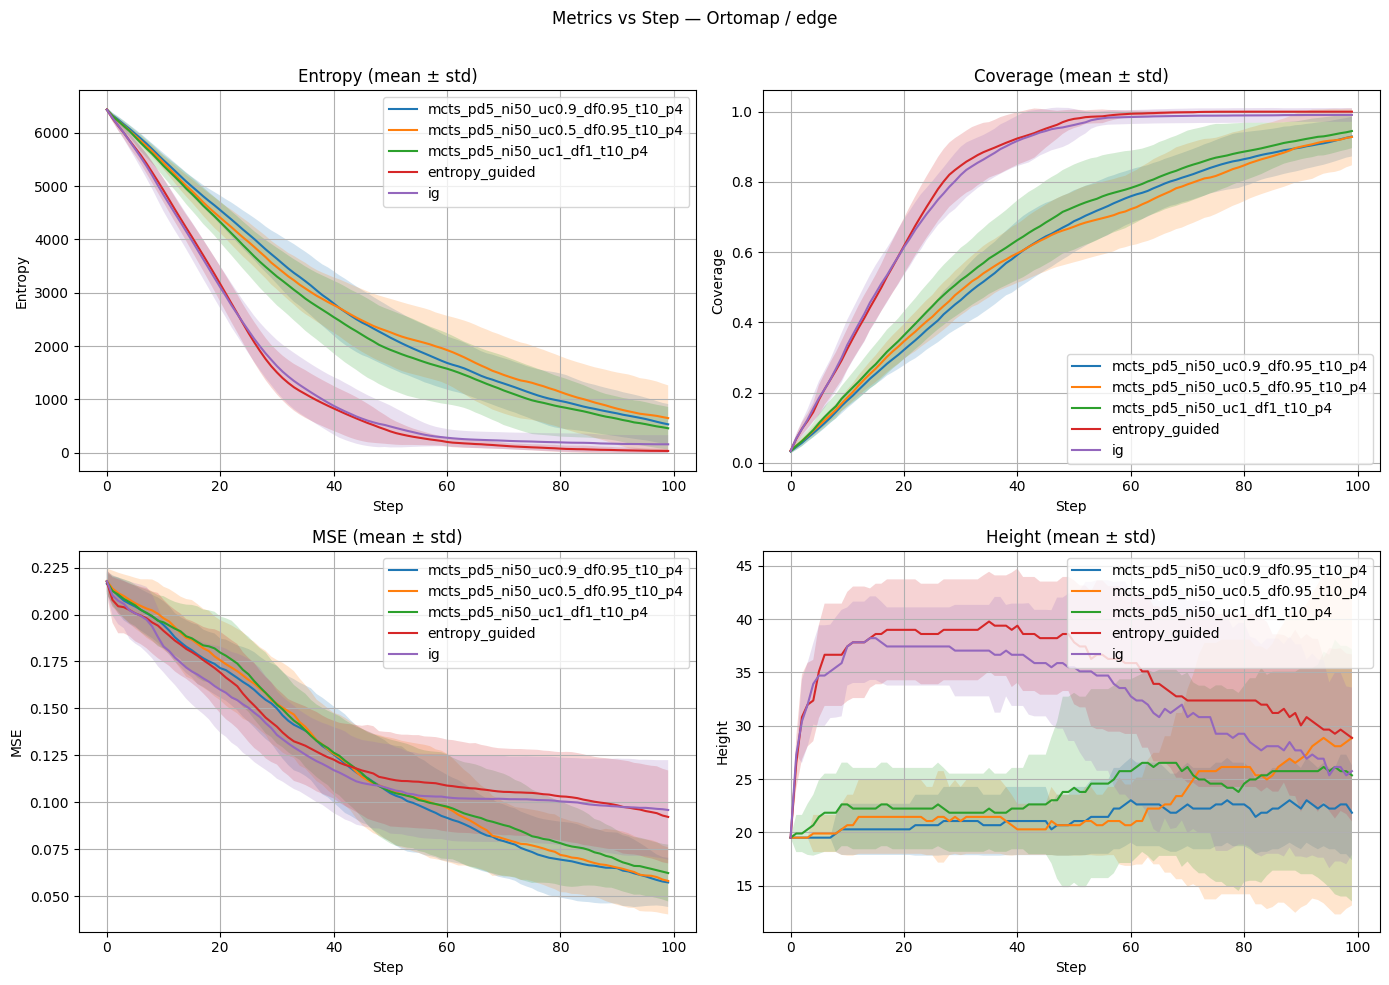

In [97]:
# Choose a slice for plotting
SLICE_FIELD = "Ortomap"  # "Ortomap" or "Gaussian"
SLICE_START = "edge"  # "corner" or "edge"
SLICE_PAIR = "equal"  # so far only "equal" tested
TOP_N = 3

# Always include 'ig' and 'entropy_guided'
ALWAYS_INCLUDE = ["ig", "entropy_guided"]

# Select only mcts-based strategies for ranking
mcts_sl = agg[
    (agg.field_type == SLICE_FIELD)
    & (agg.start_position == SLICE_START)
    & (agg.pairwise == SLICE_PAIR)
    & (agg.strategy == "mcts")
].copy()

# Rank mcts settings by final-step coverage
finals = mcts_sl.sort_values(["setting_id", "step"]).groupby("setting_id").tail(1)
ranked = finals.sort_values("mse_mean", ascending=True)
mcts_chosen = ranked.head(TOP_N).setting_id.tolist()

# Add ig and entropy_guided settings
extra_sl = agg[
    (agg.field_type == SLICE_FIELD)
    & (agg.start_position == SLICE_START)
    & (agg.pairwise == SLICE_PAIR)
    & (agg.strategy.isin(ALWAYS_INCLUDE))
].copy()
extra_settings = extra_sl["setting_id"].unique().tolist()

chosen = mcts_chosen + [sid for sid in extra_settings if sid not in mcts_chosen]
print("Selected settings:", chosen)

sl = agg[
    (agg.field_type == SLICE_FIELD)
    & (agg.start_position == SLICE_START)
    & (agg.pairwise == SLICE_PAIR)
    & (agg.setting_id.isin(chosen))
].copy()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = [
    ("entropy_mean", "entropy_std", "Entropy (mean ± std)", axs[0, 0]),
    ("coverage_mean", "coverage_std", "Coverage (mean ± std)", axs[0, 1]),
    ("mse_mean", "mse_std", "MSE (mean ± std)", axs[1, 0]),
    ("height_mean", "height_std", "Height (mean ± std)", axs[1, 1]),
]

for sid in chosen:
    d = sl[sl.setting_id == sid]
    x = d["step"].values

    for metric, err_metric, title, ax in metrics:
        y = d[metric].values
        if err_metric:
            yerr = d[err_metric].values
            ax.plot(x, y, label=sid)
            ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
        else:
            ax.plot(x, y, label=sid)
        ax.set_title(title)
        ax.set_xlabel("Step")
        ax.legend()
        ax.grid(True)


axs[0, 0].set_ylabel("Entropy")
axs[0, 1].set_ylabel("Coverage")
axs[1, 0].set_ylabel("MSE")
axs[1, 1].set_ylabel("Height")
fig.suptitle(f"Metrics vs Step — {SLICE_FIELD} / {SLICE_START}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [88]:
leader = ranked[
    [
        "setting_id",
        "coverage_mean",
        "coverage_std",
        "mse_mean",
        "mse_std",
        "entropy_mean",
        "entropy_std",
    ]
]
leader = leader.rename(
    columns={
        "coverage_mean": "final_coverage_mean",
        "coverage_std": "final_coverage_std",
        "mse_mean": "final_mse_mean",
        "mse_std": "final_mse_std",
        "entropy_mean": "final_entropy_mean",
        "entropy_std": "final_entropy_std",
    }
)
leader.head(20)

,setting_id,final_coverage_mean,final_coverage_std,final_mse_mean,final_mse_std,final_entropy_mean,final_entropy_std
4299,mcts_pd5_ni50_uc0.9_df0.95_t10_p4,0.929025,0.056466,0.05725,0.013106,533.0750,380.236943
4199,mcts_pd5_ni50_uc0.5_df0.95_t10_p4,0.928090,0.080825,0.05805,0.017849,649.5865,614.372887
4499,mcts_pd5_ni50_uc1_df1_t10_p4,0.944865,0.048698,0.06225,0.015148,459.3325,399.194455
3999,mcts_pd3_ni50_uc1_df0.95_t10_p4,0.929975,0.085478,0.06310,0.021925,578.0110,574.932826
4599,mcts_pd5_ni75_uc0.9_df0.95_t15_p1,0.953475,0.040667,0.06495,0.028557,550.2070,748.988747
4399,mcts_pd5_ni50_uc1.4_df0.95_t10_p4,0.922510,0.098867,0.07170,0.028188,808.8385,833.928298
3899,mcts_pd3_ni25_uc1_df0.95_t3_p8,0.914625,0.045676,0.07740,0.036720,983.1820,848.070681
4099,mcts_pd5_ni25_uc1_df0.95_t5_p4,0.898130,0.058764,0.08410,0.042055,1011.8015,854.054789
3799,mcts_pd3_ni10_uc1_df0.95_t5_p1,0.852205,0.171469,0.08625,0.037807,1197.9665,1304.705406
3499,entropy_guided,1.000000,0.000000,0.09215,0.024756,33.3910,37.310027
